In [4]:
!pip install wfdb

  Obtaining dependency information for wfdb from https://files.pythonhosted.org/packages/ce/00/b83d0bd64384455dbc1f8eccb7b5d6dac23728515a9d4d74aa4def6c6fe4/wfdb-4.1.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     --------- ------------------------------ 0.2/1.0 MB 7.0 MB/s eta 0:00:01
     ----------------------------------- ---- 0.9/1.0 MB 11.3 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/160.0 kB ? eta -:--:--
   ---------------------------------------- 160.0/160.0 kB ? eta 0:00:00


In [6]:
!pip install mne

  Obtaining dependency information for mne from https://files.pythonhosted.org/packages/e4/7a/2c09d230366fb43f496ee57daf6c0fa6c70129e389af62c9d34cbe852ed2/mne-1.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for pooch>=1.5 from https://files.pythonhosted.org/packages/1a/a5/5174dac3957ac412e80a00f30b6507031fcab7000afc9ea0ac413bddcff2/pooch-1.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for lazy-loader>=0.3 from https://files.pythonhosted.org/packages/a1/c3/65b3814e155836acacf720e5be3b5757130346670ac454fee29d3eda1381/lazy_loader-0.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   -- ------------------------------------- 0.6/8.3 MB 12.2 MB/s eta 0:00:01
   ----- ---------------------------------- 1.2/8.3 MB 12.2 MB/s eta 0:00:01
   -------- ------------------------------- 1.8/8.3 MB 12.6 MB/s eta 0:00:01
   ----------- ---------------------------- 2.3/8.3 MB 12.3 MB/s eta 0:00:01
   ------------- -----

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [7]:
#import numpy as np
import matplotlib.pyplot as plt
#import pyedflib
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

In [3]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [22]:
path2pt = 'D:/chb-mit-scalp-eeg-database-1.0.0/'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('\\', 2)[-2] for l in folders]]

print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [21]:
folders

['D:/chb-mit-scalp-eeg-database-1.0.0\\chb01\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb02\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb03\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb04\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb05\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb06\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb07\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb08\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb09\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb10\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb11\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb12\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb13\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb14\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb15\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb16\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb17\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb18\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb19\\',
 'D:/chb-mit-scalp-eeg-database-1.0.0\\chb20\\',
 'D:/chb-mit-scalp-e

In [23]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [24]:

files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [25]:
len(files_train), len(files_test)

(549, 137)

In [26]:
mne.set_log_level(verbose='ERROR')

In [28]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4


p = 0.01  
counter = 0
for temp_f in files_train:
    temp_edf =  mne.io.read_raw_edf(temp_f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs
            
        temp_is_sz = np.zeros((temp_edf.n_times,))
        if os.path.exists(temp_f+'.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        temp_len = temp_edf.n_times
            
        temp_is_sz_ind = np.array(
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
        )

        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

        counter = counter + temp_0_sample_size + temp_1_sample_size
    temp_edf.close()

array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)

counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = 'No. {}: Reading. '.format(n)
    temp_edf =  mne.io.read_raw_edf(temp_f)
    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
    if n_label_match==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(temp_f+'.seizures'):
            to_log = to_log+'sz exists.'
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        else:
            to_log = to_log+'No sz.'

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        temp_is_sz_ind = np.array(
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
        )
        del temp_is_sz

        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

        # sz data
        temp_ind = list(np.where(temp_is_sz_ind>0)[0])
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = True
            counter = counter+1

        # no sz data
        temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = False
            counter = counter+1

        to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
            temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
        )

    else:
        to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
        
    logger.info(to_log)
    temp_edf.close()

    if n%10==0:
        gc.collect()
gc.collect()
    
np.save('signal_samples', array_signals)
np.save('is_sz', array_is_sz)

100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [06:10<00:00,  1.48it/s]


In [29]:
array_signals.shape

(9505, 18, 2048)

In [30]:
array_signals = array_signals[:, :, ::2]

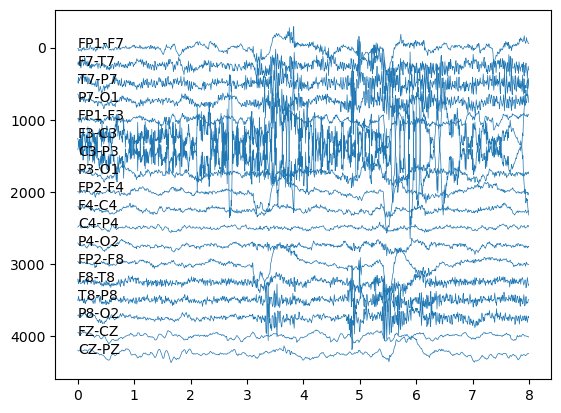

In [31]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [32]:
array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 9505
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.272


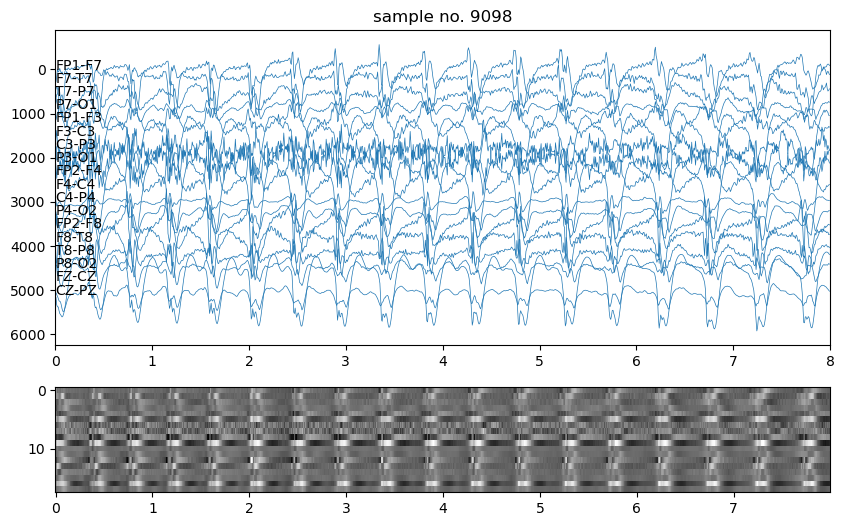

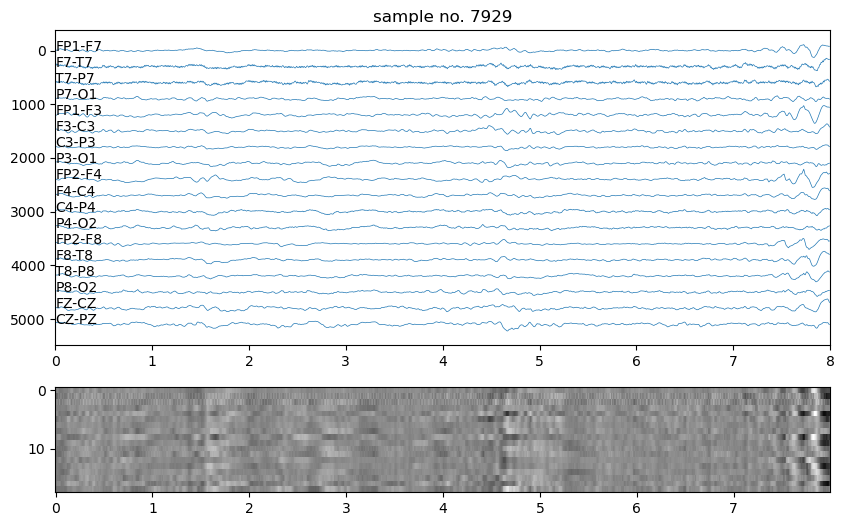

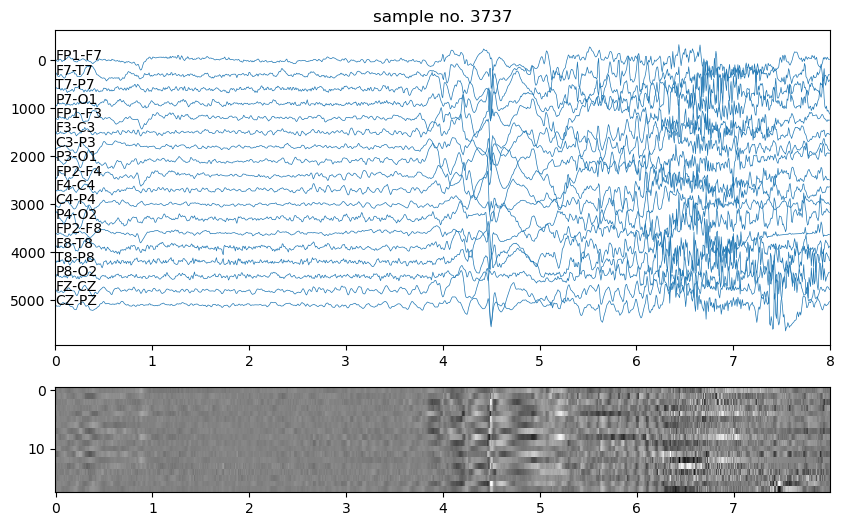

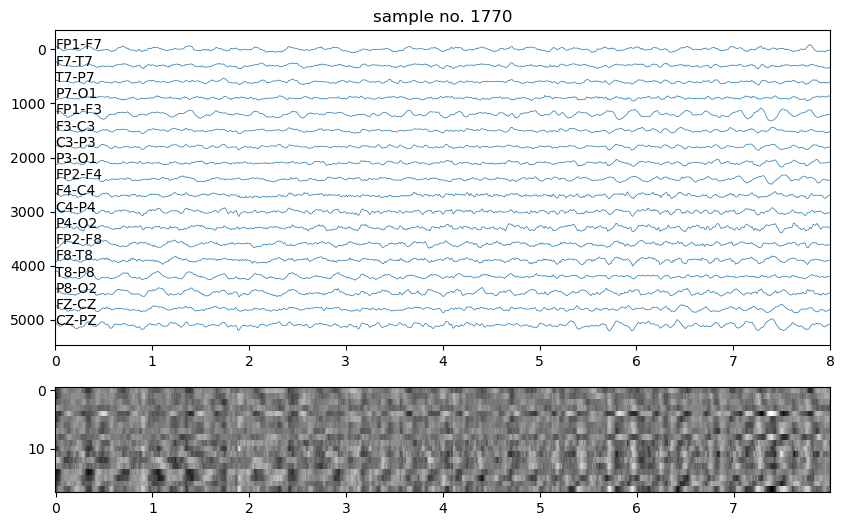

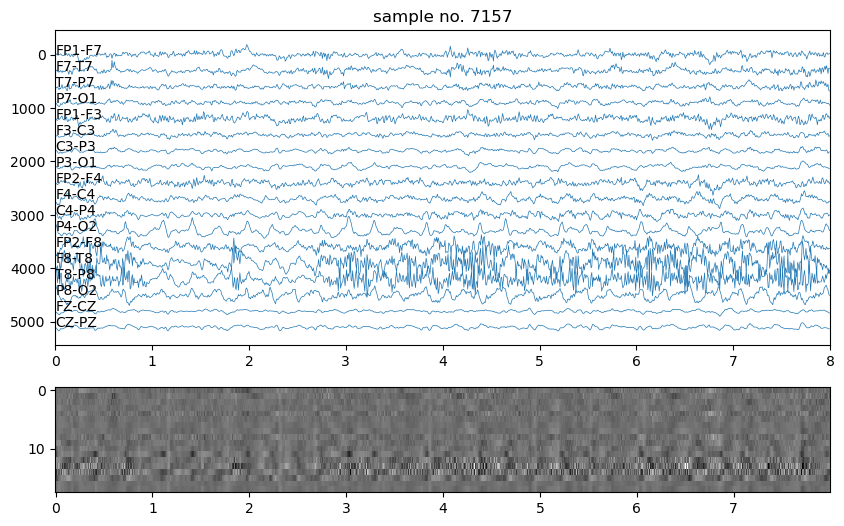

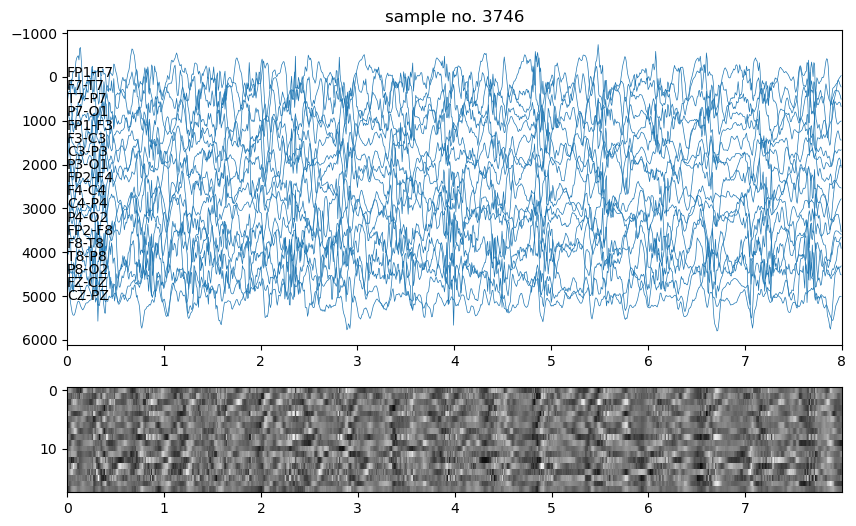

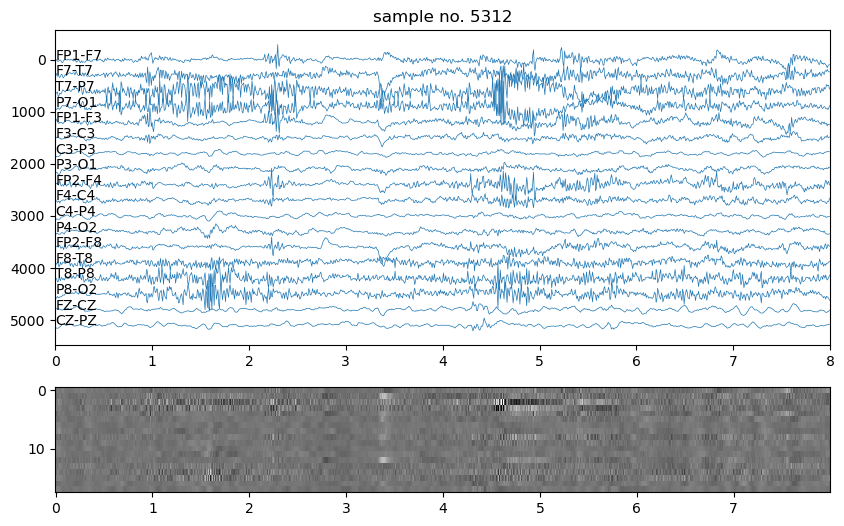

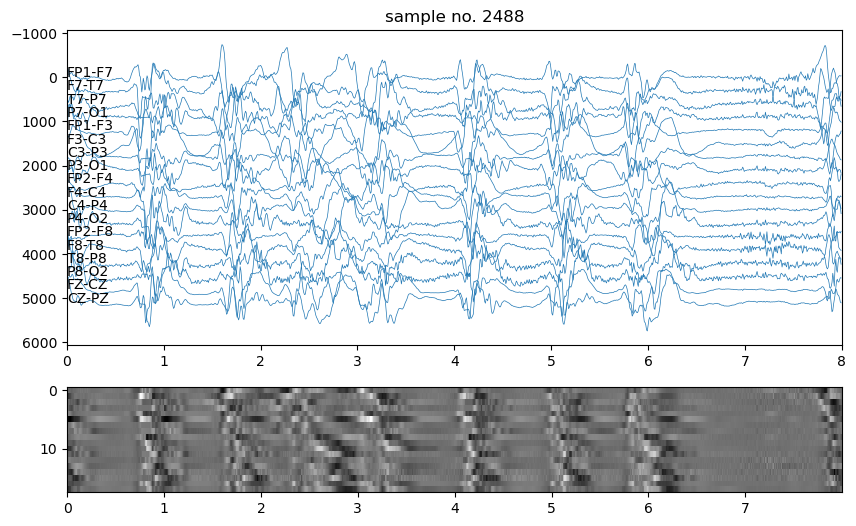

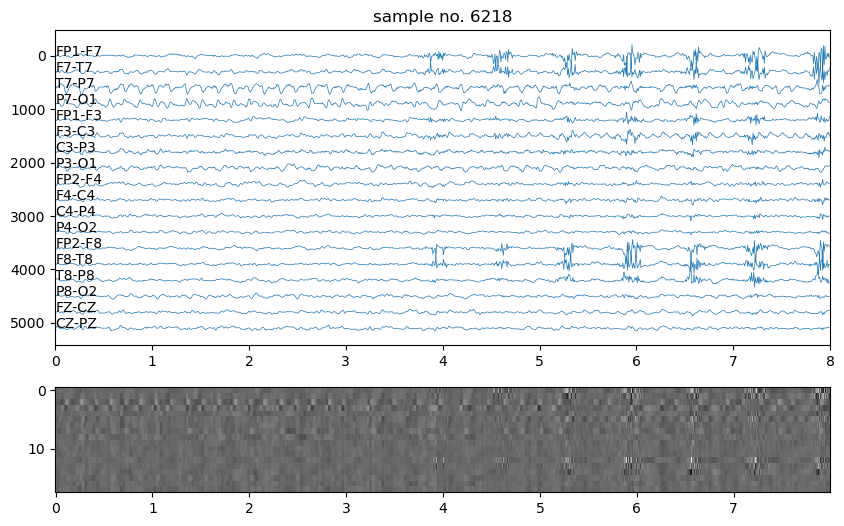

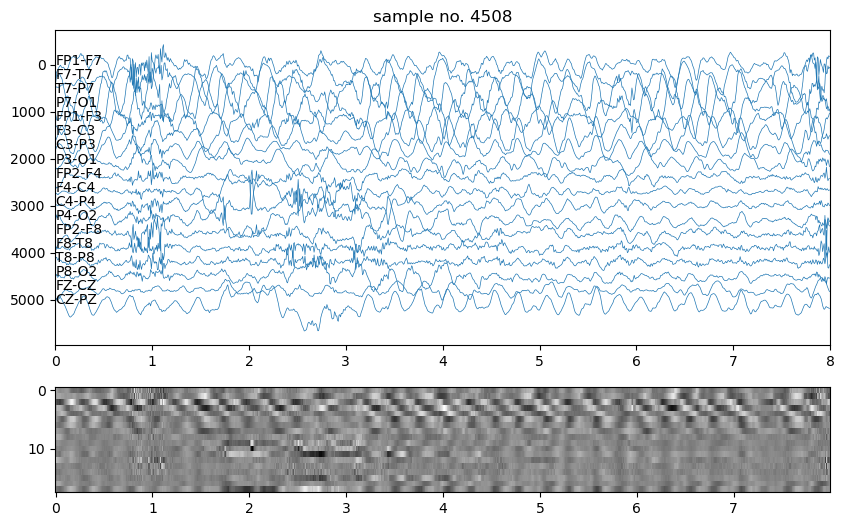

In [33]:
# Let's see samples with seizures.

for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))
    
    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()
    
    plt.show()

In [ ]:
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

In [35]:
# CNN will be used. Channel dimension is added.
array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(9505, 18, 1024, 1)

In [36]:
# splitting training data into training & validation data.

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

In [38]:
## deep learning model

model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

D:\Programfiles\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                    │ (None, 18, 1024, 64)          │         576 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)                  │ (None, 18, 512, 64)           │      32,832 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d (MaxPooling2D)       │ (None, 18, 256, 64)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_2 (Conv2D)                  │ (None, 18, 256, 128)          │      65,664 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_3 (Conv2D)                  │ (None, 18, 128, 128)          │     131,200 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_1 (MaxPooling2D)     │ (None, 9, 64, 128)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_4 (Conv2D)                  │ (None, 9, 64, 256)            │     524,544 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_5 (Conv2D)                  │ (None, 9, 32, 256)            │   1,048,832 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_2 (MaxPooling2D)     │ (None, 9, 16, 256)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_average_pooling2d           │ (None, 256)                   │           0 │
│ (GlobalAveragePooling2D)           │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 256)                   │      65,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 256)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 128)                   │      32,896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 64)                    │       8,256 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 64)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_3 (Dense)                    │ (None, 1)                     │          65 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,910,657 (7.29 MB)

 Trainable params: 1,910,657 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
!pip install pydot

#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [45]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [47]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6653, 18, 1024, 1), (6653,), (2852, 18, 1024, 1), (2852,))

In [61]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 478s 18s/step - accuracy: 0.7984 - loss: 0.5036 - val_accuracy: 0.8193 - val_loss: 0.4577
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 465s 18s/step - accuracy: 0.7972 - loss: 0.4930 - val_accuracy: 0.8048 - val_loss: 0.4874
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 461s 18s/step - accuracy: 0.8268 - loss: 0.4527 - val_accuracy: 0.8414 - val_loss: 0.4087
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 461s 18s/step - accuracy: 0.8317 - loss: 0.4078 - val_accuracy: 0.8541 - val_loss: 0.3892
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 462s 18s/step - accuracy: 0.8483 - loss: 0.3866 - val_accuracy: 0.8450 - val_loss: 0.3871
Restoring model weights from the end of the best epoch: 5.


In [62]:
model.save('CHB_MIT_sz_detec_demo.h5')

D:\Programfiles\anaconda3\Lib\site-packages\keras\src\models\model.py:342: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  warnings.warn(


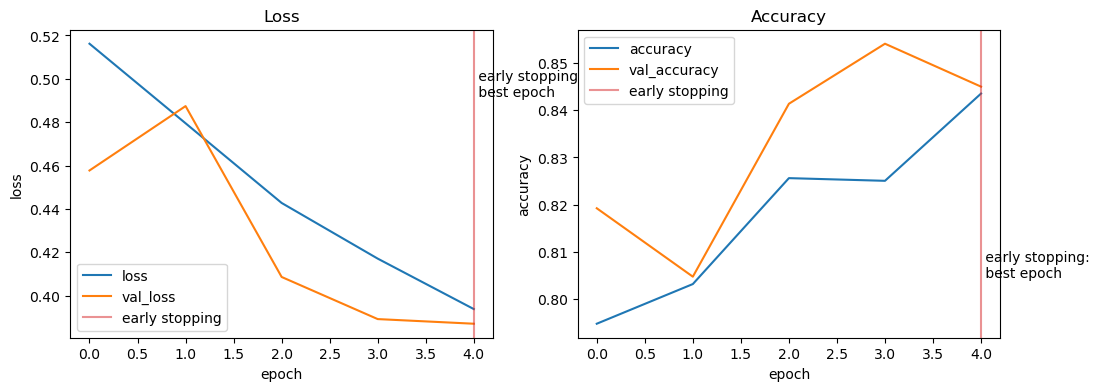

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [64]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [65]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]
    
    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [1:03:12<00:00, 27.68s/it]


In [67]:
from sklearn import metrics
# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    186865
        True       0.10      0.42      0.16       629

    accuracy                           0.99    187494
   macro avg       0.55      0.70      0.58    187494
weighted avg       0.99      0.99      0.99    187494



In [68]:
# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    186865
        True       0.53      0.21      0.30       629

    accuracy                           1.00    187494
   macro avg       0.77      0.60      0.65    187494
weighted avg       1.00      1.00      1.00    187494



In [69]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

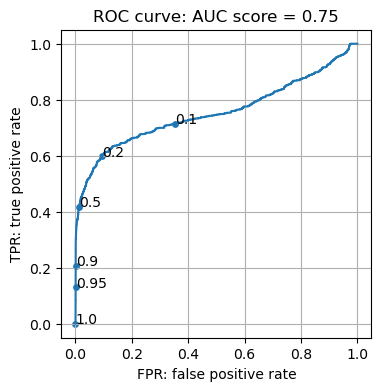

In [70]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

In [71]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 2 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_03.edf
Index = 3 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_04.edf
Index = 14 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_15.edf
Index = 15 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_16.edf
Index = 17 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_18.edf
Index = 20 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_21.edf
Index = 25 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb01\chb01_26.edf
Index = 53 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb07\chb07_12.edf
Index = 54 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb07\chb07_13.edf
Index = 60 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb07\chb07_19.edf
Index = 61 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb08\chb08_02.edf
Index = 64 has seizures: D:/chb-mit-scalp-eeg-database-1.0.0//chb08\chb08_05.edf
Index = 66 has seizures: D:/ch

In [72]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n
    
    return temp

In [73]:
# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

D:/chb-mit-scalp-eeg-database-1.0.0//chb10\chb10_27.edf: Reading. 
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step


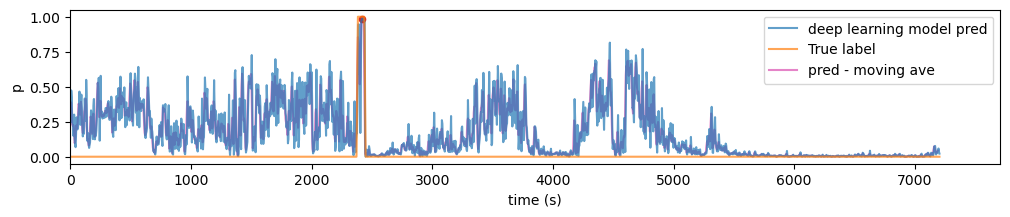

In [74]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()



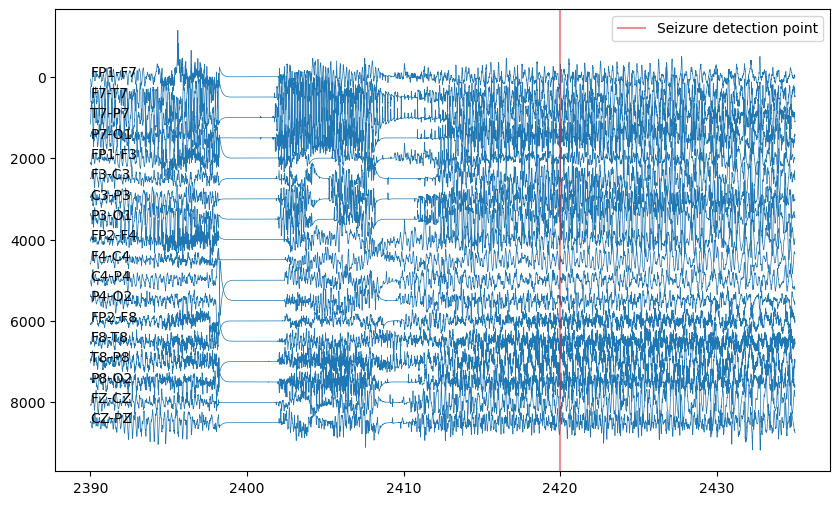

In [75]:
if pred_peaks.size==0:
    print('No seizure detected.')
else:
    f = files_test[n]
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

    fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
    for n_peak in range(pred_peaks.size):
        ind_peak = pred_peaks[n_peak]*time_step*fs
        backward_steps = 30*fs
        forward_steps = 15*fs
        vertical_width=500

        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(temp_signals.shape[0]):
            ax.plot(np.arange(ind_peak-backward_steps, ind_peak+forward_steps)/fs,
                    temp_signals[i, ind_peak-backward_steps:ind_peak+forward_steps]+i*vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(ch_labels[i], xy=((ind_peak-backward_steps)/fs, i*vertical_width))
        ax.axvline(x=ind_peak/fs, color='tab:red', alpha=0.5, label='Seizure detection point')
        ax.invert_yaxis()
        ax.legend(loc='upper right')
        plt.show()
    #ax.set_xlim(0, 8)

    temp_edf.close()